In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from torch.optim import Adam
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [17]:
means = [0.49139968, 0.48215841, 0.44653091]
stds = [0.24703223, 0.24348513, 0.26158784]

train_transforms = T.Compose(
    [
        T.RandomRotation(10)
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10("/home/jupyter/mnt/datasets/cifar10", train=True, transform=train_transforms)
valid_dataset = CIFAR10("/home/jupyter/mnt/datasets/cifar10", train=False, transform=test_transforms)



SyntaxError: invalid syntax (<ipython-input-1-5b17823947ab>, line 7)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy





def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )


In [13]:
class FourthModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 64 x 64 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 64 x 64 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 32 x 32 x 32
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 32 x 32 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 32 x 32 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 64
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 16 x 16 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 16 x 16 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 128
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # 8 x 8 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),  # 8 x 8 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 256
            nn.Dropout2d(p=0.25),

            nn.Flatten(),

            nn.Linear(4 * 4 * 256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step()

In [10]:
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            y_pred = torch.argmax(output, dim=1)
            predictions.append(y_pred)
    result = torch.cat(predictions)
    return result

In [29]:
@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()
    iter = []
    with torch.no_grad():
        for i in range(iterations):
            predicts = []
            for x, y in loader:
                out = model(x)
                predicts.append(out)
            iter.append(torch.concat(predicts))
    return torch.concat(iter).reshape(iterations, len(loader.dataset), out.size(1)).mean(dim=0).argmax(dim=1)

In [8]:
def create_simple_conv_cifar():
    model = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
                nn.BatchNorm2d(16),
                nn.ReLU(),

                nn.MaxPool2d(2),  # 16 x 16 x 16
                nn.Dropout2d(p=0.2),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.MaxPool2d(2),  # 8 x 8 x 32
                nn.Dropout2d(p=0.2),

                nn.Flatten(),
                nn.Linear(8 * 8 * 32, 1024),
                nn.BatchNorm1d(1024),
                nn.Dropout(p=0.2),
                nn.ReLU(),
                nn.Linear(1024, 128),
                nn.BatchNorm1d(128),
                nn.Dropout(p=0.2),
                nn.ReLU(),
                nn.Linear(128, 10)
            )
    return model

In [23]:
def create_advanced_conv_cifar():
    return nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),  # 64 x 64 x 32
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 64 x 64 x 32
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 32 x 32 x 32
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 32 x 32 x 64
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 32 x 32 x 64
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 64
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # 16 x 16 x 128
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),  # 16 x 16 x 128
            nn.BatchNorm2d(256),
            nn.ReLU(),


            nn.MaxPool2d(2),  # 4 x 4 x 256
            nn.Dropout2d(p=0.25),

            nn.Flatten(),

            nn.Linear(4 * 4 * 256, 10),
        )

In [14]:
def get_augmentations(train: bool = True) -> T.Compose:
    if train == True:
        transforms = T.Compose([
            T.Resize((64,64)),
            T.RandomCrop(size=64, padding=8, padding_mode='reflect'),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomAdjustSharpness(sharpness_factor=2, p=0.4),
            T.ToTensor(),
            T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))        
        ])
    else:
        transforms = T.Compose([
            T.Resize((64,64)),
            T.ToTensor(),
            T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))        
        ])
    return transforms


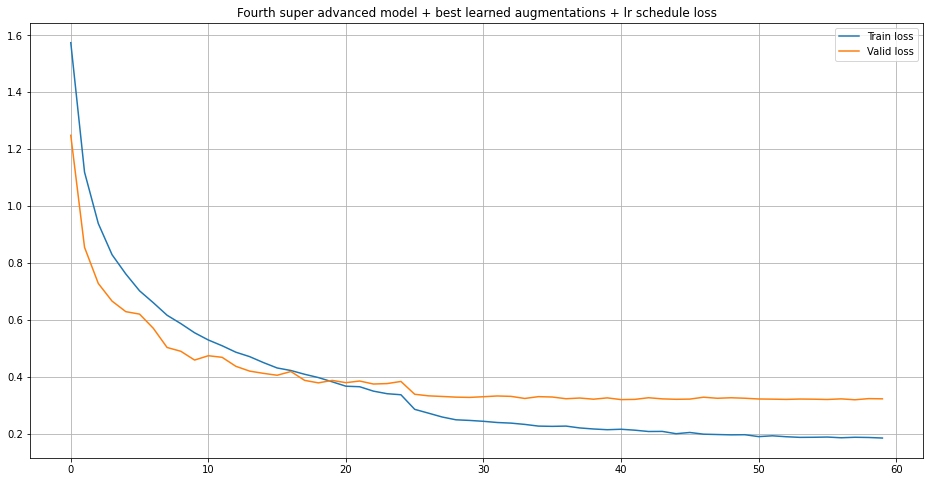

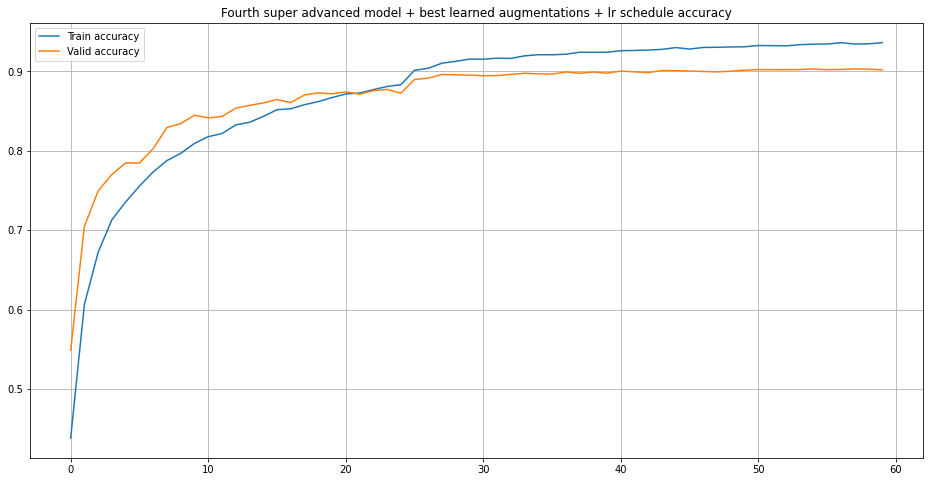

In [32]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()

model = create_advanced_conv_cifar().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)

#whole_train_valid_cycle(model, 30, 'Fourth super advanced model + custom augmentations')
result = whole_train_valid_cycle_with_scheduler(model, 60, 'Fourth super advanced model + best learned augmentations + lr schedule')

prediction = predict(model, valid_loader, device)
torch.save(prediction, 'model.pth')